# Libraries

In [1]:
import tensorflow as tf
import gym
import numpy as np
from stable_baselines import DQN #type: ignore
from copy import deepcopy
import math
from gym.spaces import Discrete, Dict, Box
from gym import spaces
from random import seed
import random 
from gym import Env
from datetime import datetime
import sys
import time
import pickle
import stable_baselines
import sklearn
from sklearn import tree , svm 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB , CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix #type: ignore
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score
from itertools import product
from sklearn.utils import resample
from sklearn.model_selection import KFold , RepeatedKFold
from sklearn.metrics import f1_score
from sklearn import impute
import statistics
from scipy import stats
from copy import deepcopy
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from math import ceil
import copy
import sys
from sklearn.metrics import jaccard_score
import time
import multiprocessing
from pymoo.algorithms.nsga2 import calc_crowding_distance
sys.path.append('lib/')
import subprocess
import logging
from sklearn.utils import shuffle
import csv
from csv import reader
import os
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score
from tqdm import tqdm

class StoreWrapper(gym.Wrapper):
  ''''
  :param env: (gym.Env) Gym environment that will be wrapped
  :param max_steps: (int) Max number of steps per episode
  '''
  def __init__(self, env):
    # Call the parent constructor, so we can access self.env later
    super(StoreWrapper, self).__init__(env)
    self.max_steps = 200
    # Counter of steps per episode
    self.current_step = 0
    self.mem = []
    self.TotalReward = 0.0 
    self.env = env
    self.first_state = 0
    self.first_obs = 0
    self.prev_obs = 0 
    self.states_list = []
    self.info = {}
  
  def reset(self):
    """
    Reset the environment 
    """
    # Reset the counter
    self.current_step = 0
    obs =self.env.reset()
    self.TotalReward = 0.0
    self.first_obs = obs
    return obs

  def step(self, action):
    """
    In this function we store the initial state as well as the memory of the agent
    :param action: ([float] or int) Action taken by the agent
    :return: (np.ndarray, float, bool, dict) observation, reward, is the episode over?, additional informations
    """
    if self.current_step == 0: #store initial state
      self.prev_obs = self.first_obs
      self.first_state = deepcopy(self.env)
      self.states_list.append(self.first_state)
    self.current_step += 1
    obs, reward, done, info = self.env.step(action)
    self.TotalReward += reward
    self.mem.append(tuple((self.prev_obs,action)))
    self.prev_obs = obs
    if self.current_step >= self.max_steps:
      done = True
      # Update the info dict to signal that the limit was exceeded
    if done:
      self.mem.append(tuple(('done',self.TotalReward)))
    self.info['mem'] = self.mem
    self.info['state'] = self.states_list
    # self.mem.append(tuple(obs,action))
    return obs, reward, done, info

  def set_state(self, state):
    """
    :param state: initial state of the episode
    :return: environment is updated and observations is returned
    """
    self.env = deepcopy(state)
    obs = np.array(list(self.env.unwrapped.state))
    self.current_step = 0
    self.TotalReward = 0.0
    self.first_obs = obs
    return obs

def abstract_state(model,state1,d):
  if type(state1) == str:
    if state1 == 'done':
      return 'end'
  q_value1 = model.step_model.step([state1])
  return( ceil(q_value1[1][0][0]/d), ceil(q_value1[1][0][1]/d))

def abstract_state_general(model,state1,d):
  if type(state1) == str:
    if state1 == 'done':
      return 'end'
  q_values = model.step_model.step([state1])
  return tuple([ceil(q_value/d) for q_value in q_values[1][0]])

def Abstract_classes(ep,abstraction_d,model):
  d=abstraction_d
  abs_states1=[]
  for episode in ep:
    for state,action in episode:
      abs_st = abstract_state(model,state,d)
      if abs_st == 'end':
        continue
      abs_states1.append(abs_st)
  unique1=list(set(abs_states1))
  uni1 = np.array(unique1)
  a=len(abs_states1)
  b=len(set(abs_states1))
  print("abstract states:",b)
  print("Concrete states",a)
  print("ratio",b/a)
  return unique1,uni1

def is_functional_fault(episode,epsilon):
  for state, _ in episode:
    if type(state) == str:
      if state == 'done':
        return False
    if abs(state[0]) >= (2.4-epsilon):
      return True
  # no functional fault is obsereved
  return False

def is_reward_fault(episode,threshold):
  last_state = episode[-1]
  assert last_state[0] == 'done'
  if last_state[1] < threshold:
    return True
  else:
    return False

def ML_first_representation_func_based(Abs_d,functional_func,reward_func,model,input_episodes,unique1,epsilon,threshold):
  """
  TO-DO : fix epsilon and threshold
  """
  d = Abs_d
  data1_x_b=[]
  data1_y_b= [] 
  data1_y_f_b = []
  for i, episode in enumerate(input_episodes):
    record = np.zeros(len(unique1))
    temp_flag = False
    for state, action in episode:
      ab = abstract_state(model,state,d)
      if ab == 'end':
        assert not temp_flag, f'Episode data problem, two terminations in one episode. Episode number{i}'
        temp_flag = True
        # print(action)
        # print(functional_func(episode))
        if functional_func(episode,epsilon):
          data1_y_f_b.append(1)
        else:
          data1_y_f_b.append(0)
        if reward_func(episode,threshold):
          data1_y_b.append(1)
        else:
          data1_y_b.append(0)
        # print("end\n\n\n")
        # print(len(data1_y_b),"len(input_episodes)",len(input_episodes))
        continue
        # print(state[0])
      ind = unique1.index(ab)
      record[ind] = 1
      # print(state, action)
      assert len(data1_y_b)<len(input_episodes), "assert"
      # if you want the frequency go with the next line 
      # record[ind] += 1
    data1_x_b.append(record)

  return data1_x_b, data1_y_b, data1_y_f_b


def ML_first_representation(Abs_d,epsilon_functional_fault_boarder,model,ep,unique1):
  d = Abs_d
  # epsilon = 0.05
  epsilon = epsilon_functional_fault_boarder
  data1_x_b=[]
  data1_y_b= [] 
  data1_y_f_b = []
  functional_fault = False
  reward_fault_threshold = 70
  for episode in ep:
    record = np.zeros(len(unique1))
    for state, action in episode:
      ab = abstract_state(model,state,d)
      if ab == 'end':
        # print(action)
        if functional_fault:
          data1_y_f_b.append(1)
        else:
          data1_y_f_b.append(0)
        if action >= reward_fault_threshold:
          data1_y_b.append(0)
        else:
          data1_y_b.append(1)
        functional_fault=False
        continue
      if abs(state[0]) >= (2.4-epsilon) :
        functional_fault = True
      ind = unique1.index(ab)
      # if len(w[0])>1:
        # print('error len is greater than 1')
      record[ind] = 1
      # if you want the frequency go with the next line 
      # record[ind] += 1
    data1_x_b.append(record)

  return data1_x_b, data1_y_b, data1_y_f_b

#report function to check the performance metrics of the model
def report(model2,x_train, y_train,x_test, y_test):
  print("********************** reporting the result of the model **************************")
  print('The score for train data is {0}'.format(model2.score(x_train,y_train)))
  print('The score for test data is {0}'.format(model2.score(x_test,y_test)))


  predictions_train = model2.predict(x_train)
  predictions_test = model2.predict(x_test)

  print("\n\n--------------------------------------recall---------------------------------")

  print('the test recall for the class yes is {0}'.format(metrics.recall_score(y_test,predictions_test, pos_label=1)))
  print('the test recall for the class no is {0}'.format(metrics.recall_score(y_test,predictions_test, pos_label=0)))

  print('the training recall for the class yes is {0}'.format(metrics.recall_score(y_train,predictions_train, pos_label=1)))
  print('the training recall for the class no is {0}'.format(metrics.recall_score(y_train,predictions_train, pos_label=0)))


  print("\n\n--------------------------------------precision------------------------------")


  print('the test precision for the class yes is {0}'.format(metrics.precision_score(y_test,predictions_test, pos_label=1)))
  print('the test precision for the class no is {0}'.format(metrics.precision_score(y_test,predictions_test, pos_label=0)))

  print('the training precision for the class yes is {0}'.format(metrics.precision_score(y_train,predictions_train, pos_label=1)))
  print('the training precision for the class no is {0}'.format(metrics.precision_score(y_train,predictions_train, pos_label=0)))

  print("\n\n")
  print(classification_report(y_test, predictions_test, target_names=['NO ','yes']))

  tn, fp, fn, tp = confusion_matrix(y_test, predictions_test).ravel()
  specificity = tn / (tn+fp)
  print("\n\nspecifity :",specificity)
  print("\n\n--------------------------------------confusion----------------------------")
  CM = metrics.confusion_matrix(y_test, predictions_test)
  print("The confusion Matrix:")
  print(CM)
  print('the accuracy score in {0}\n\n'.format(accuracy_score(y_test, predictions_test)))
  print("********************** plotting the confusion matrix & ROC curve **************************")
  plot_confusion_matrix(model2, x_test, y_test) #type: ignore
  metrics.plot_roc_curve(model2, x_test, y_test)  #type: ignore
  plt.show()



def random_test_2(model, env, Num):
  obs=env.reset()
  counter = 1
  episode_reward = 0.0
  end =-1
  lastpoint = -1
  for i in range(Num):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    episode_reward += reward
    if done:
      counter += 1
      end = i
      episode_reward = 0.0
      obs = env.reset()
  iter = deepcopy(counter)
  u=1
  while iter>1:
    if env.info['mem'][-u][0]=='done': 
      lastpoint = -u
      iter -= 1
    u+=1
  assert lastpoint != -1
  assert end != -1
  fin =Num - end
  start = -Num -counter
  randomtest = env.info['mem'][lastpoint:-fin] 
  ran_state = env.info['state'][(-counter+1):-1] 
  return randomtest , ran_state

def fix_testing(testing_episodes,testing_states,Env2):
  # TO DO: fix data typr for if condition change to nparray
  buffer =[] 
  episodes_set = []
  j=0
  for i in range(len(testing_episodes)):
    if testing_episodes[i][0] == 'done':
      if i == 0:
        continue
      buffer.append(testing_episodes[i])
      episodes_set.append(buffer)
      buffer=[]
    else:
      buffer.append(testing_episodes[i])
  if not (np.array(episodes_set[0][0][0])== np.array(Env2.set_state(testing_states[0]),dtype="float32")).all():
    del testing_states[0]
  if not (np.array(episodes_set[0][0][0])==np.array(Env2.set_state(testing_states[0]),dtype="float32")).all():
    assert False, 'problem in starting states'
  if len(episodes_set)!=len(testing_states):
    del testing_states[-1]
  if len(episodes_set)!=len(testing_states):
    assert False, 'problem in data prepration'
  return episodes_set , testing_states





c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ale_py\roms\utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [3]:
#Address of the trained RL model 
Dataset_path = "Path to the dataset"

Drive_model  =f"{Dataset_path}/Trained_agent/dqn-168.pkl"


env2 = gym.make('CartPole-v1')
env2 = StoreWrapper(env2)
model = DQN('MlpPolicy',env=env2, verbose=1)
model = model.load(Drive_model)
#########################################################  Read DATA and Load Model #############


Loading a model without an environment, this model cannot be trained until it has a valid environment.


# generate training data

In [10]:
EPSILON = 0.05
THRESHOLD = 70
TRAINING_SIZE = 2200

RT,RTS = random_test_2(model,env2,500_000)
FRT,FRTS = fix_testing(RT,RTS,env2)

if len(FRT) < TRAINING_SIZE:
    assert False, "Not enough data for training increase the number of random test"
else:
    FRT = FRT[:TRAINING_SIZE]
    FRTS = FRTS[:TRAINING_SIZE]


RF=0
FF=0
Buff_reward = 0
Buff_len = 0
for test_episode in FRT:
    Buff_reward += test_episode[-1][1]
    Buff_len += (len(test_episode)-1)
    if is_functional_fault(test_episode,EPSILON):
        FF+=1
    if is_reward_fault(test_episode,THRESHOLD):
        RF+=1


Functional_Fault_rate = FF/len(FRT)
Reward_Fault_rate = RF/len(FRT)
print("Reward fault rate:",Reward_Fault_rate)
print("Functional fault rate:",Functional_Fault_rate)
print("Average Reward:",Buff_reward/len(FRT))
print("Average Lenght:",Buff_len/len(FRT))
print("Number of episodes:",len(FRT))
print("Number of functional faulty episodes:",FF)

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:317: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:335: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Reward fault rate: 0.0
Functional fault rate: 0.09772727272727273
Average Reward: 193.16454545454545
Average Lenght: 193.16454545454545
Number of episodes: 2200
Number of functional faulty episodes: 215


In [15]:
#save frt:random episodes and frts:initial state of random episodes as pickle file

with open('Data_final/Random_episodes/FRT_68_training.pkl', 'wb') as f:
    pickle.dump(FRT, f)
with open('Data_final/Random_episodes/FRTS_68_training.pkl', 'wb') as f:
    pickle.dump(FRTS, f)


# Testing Data Generation

In [20]:
EPSILON = 0.05
THRESHOLD = 70
TEST_SIZE = 1000

RT,RTS = random_test_2(model,env2,200_000)
FRT,FRTS = fix_testing(RT,RTS,env2)

if len(FRT) < TEST_SIZE:
    assert False, "Not enough data for training increase the number of random test"
else:
    FRT = FRT[:TEST_SIZE]
    FRTS = FRTS[:TEST_SIZE]


RF=0
FF=0
Buff_reward = 0
Buff_len = 0
for test_episode in FRT:
    Buff_reward += test_episode[-1][1]
    Buff_len += (len(test_episode)-1)
    if is_functional_fault(test_episode,EPSILON):
        FF+=1
    if is_reward_fault(test_episode,THRESHOLD):
        RF+=1


Functional_Fault_rate = FF/len(FRT)
Reward_Fault_rate = RF/len(FRT)
print("Reward fault rate:",Reward_Fault_rate)
print("Functional fault rate:",Functional_Fault_rate)
print("Average Reward:",Buff_reward/len(FRT))
print("Average Lenght:",Buff_len/len(FRT))
print("Number of episodes:",len(FRT))
print("Number of functional faults:",FF)
#save frt and frts as pickle file

with open('Data_final/Random_episodes/FRT_test_68.pkl', 'wb') as f:
    pickle.dump(FRT, f)
with open('Data_final/Random_episodes/FRTS_test_68.pkl', 'wb') as f:
    pickle.dump(FRTS, f)


c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:317: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:335: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Reward fault rate: 0.0
Functional fault rate: 0.099
Average Reward: 192.99
Average Lenght: 192.99
Number of episodes: 1000
Number of functional faults: 99


In [ ]:
##Extracting test dataset stats, specially minimum length of episodes

EPSILON = 0.05
THRESHOLD = 70

with open(f'C:/Users/Student/Desktop/vs_git/HazardDetection/Final/Data_final/Random_episodes/FRT_test_68.pkl', 'rb') as file2:
    FRT = pickle.load(file2)

RF=0
FF=0
Buff_reward = 0
Buff_len = 0
min_len = 1000

for test_episode in FRT:
    Buff_reward += test_episode[-1][1]
    Buff_len += (len(test_episode)-1)
    min_len = min(min_len,len(test_episode)-1)
    if is_functional_fault(test_episode,EPSILON):
        FF+=1
    if is_reward_fault(test_episode,THRESHOLD):
        RF+=1


Functional_Fault_rate = FF/len(FRT)
Reward_Fault_rate = RF/len(FRT)
print("Reward fault rate:",Reward_Fault_rate)
print("Functional fault rate:",Functional_Fault_rate)
print("Average Reward:",Buff_reward/len(FRT))
print("Average Lenght:",Buff_len/len(FRT))
print("Number of episodes:",len(FRT))
print("Number of functional faults:",FF)
print("Number of reward faults:",RF)
print("Min length:",min_len)




Reward fault rate: 0.0
Functional fault rate: 0.099
Average Reward: 192.99
Average Lenght: 192.99
Number of episodes: 1000
Number of functional faults: 99
Number of reward faults: 0
Min length: 118


# Functions

In [ ]:
def translator(episode,model, d, unique5):
  """
  this function takes the concrete episodes and returns the encoded episodes 
  based on the presence and absence of the individuals  
  :param 'episode': input episode
  :param 'model': RL model
  :param 'd': abstraction level = 1
  :param 'unique5': abstract classes 
  :return: encoded episodse based on the presence and absence

  """
  d=d
  record = np.zeros(len(unique5))
  for state, action in episode:
    ab = abstract_state(model,state,d)
    if ab == 'end':
      continue
    if ab in unique5:
      ind = unique5.index(ab)
      record[ind] = 1
  return [record]

def episode_player(episodes,d, abs_classes, model, monitor) -> list:
  ''' This function replays the episodes and returns the risk of each step in each episode
  :param 'episodes': input episodes
  :param 'd': abstraction level 
  :param 'abs_classes': abstract classes
  :param 'model': RL model
  :param 'monitor': ML model
  :return: risk of each step in each episode
  
  '''
  episodes_risk=[]
  for episode in episodes:
    risk_array=[]
    for step in range(len(episode)-1):
      monitoring_data = translator(episode[:step],model,d,abs_classes)
      Risk = monitor.predict_proba(monitoring_data)
      risk_array.append(Risk[0][1])
    episodes_risk.append(risk_array)
  return episodes_risk

def single_episode_player(episode,d, abs_classes, model, monitor) -> list:
  ''' This function replays one episodes and returns the risk of each step in episode
  :param 'episode': input episode
  :param 'd': abstraction level
  :param 'abs_classes': abstract classes
  :param 'model': RL model
  :param 'monitor': ML model
  :return: risk of each step in episode
  '''
  risk_array=[]
  for step in range(len(episode)-1):
    monitoring_data = translator(episode[:step],model,d,abs_classes)
    Risk = monitor.predict_proba(monitoring_data)
    risk_array.append(Risk[0][1])
  return risk_array


def position_extractor(episode):
    position =[]
    for i in range(len(episode)-1):
        position.append(episode[i][0][0])
    return position
    
def velocity_extractor(episode):
    velocity =[]
    for i in range(len(episode)-1):
        velocity.append(episode[i][0][1])
    return velocity
def angle_extractor(episode):
    angle =[]
    for i in range(len(episode)-1):
        angle.append(episode[i][0][2])
    return angle
def angular_v_extractor(episode):
    angular_v =[]
    for i in range(len(episode)-1):
        angular_v.append(episode[i][0][3])
    return angular_v



def Plot_all(data,abstraction_level,unique1,RL_model,Monitor,save=False,show=True,data_chunk=0,path='C:/Users/Student/Desktop/vs_git/HazardDetection/CartPole/Plots_CartPole'):
    '''plot risk and position snd velocity in one figure with 3 subplots
    '''
    ## TODO: write a function to return the setteings of the environment and the model

    fig, axs = plt.subplots(5,figsize=(20, 18))
    for i in range(len(data)):
        axs[0].plot([i for i in range(len(data[i])-1)], single_episode_player(data[i],abstraction_level,unique1,RL_model,Monitor), label = f"Episode {i}")
        axs[1].plot([i for i in range(len(data[i])-1)], position_extractor(data[i]), label = f"Episode {i}")
        axs[2].plot([i for i in range(len(data[i])-1)], velocity_extractor(data[i]), label = f"Episode {i}")
        axs[3].plot([i for i in range(len(data[i])-1)], angle_extractor(data[i]), label = f"Episode {i}")
        axs[4].plot([i for i in range(len(data[i])-1)], angular_v_extractor(data[i]) ,label = f"Episode {i}")
    axs[0].legend()
    #plot title and labels
    axs[0].set_title('Risk')
    axs[1].legend()
    axs[1].set_title('Position')
    axs[2].set_title('Velocity')
    axs[3].set_title('Angle')
    axs[4].set_title('Angular Velocity')
    axs[2].legend()
    axs[3].legend()
    axs[4].legend()
    #set range of y axis
    axs[0].set_ylim(-0.1, 1.1)
    
    current_time = datetime.now()
    ID = current_time.strftime("%Y%m%d%H%M%S")
    if save:
        fig.savefig(f'{path}/RPVAA2_C{data_chunk}_{ID}.png')
    #close the plot
    plt.close()

def translate_episode_steps(episode,HD_model,translator,d,abs_classes):
    translated_episode = []
    for i in range(len(episode)-1):
        translated_episode.append(translator(episode[:i],HD_model,d,abs_classes))
    return translated_episode

def translate_multiple_episodes_steps(episodes,HD_model,translator,d,abs_classes):
    translated_episodes = []
    for episode in episodes:
        translated_buffer = []
        for i in range(len(episode)-1):
            translated_buffer.append(translator(episode[:i],HD_model,d,abs_classes))
        translated_episodes.append(translated_buffer)
    return translated_episodes


Loading a model without an environment, this model cannot be trained until it has a valid environment.
Number of episodes: 2200



#########################################
Abstraction level: 5
abstract states: 32
Concrete states 424962
ratio 7.530085042897953e-05
********************** reporting the result of the model **************************
The score for train data is 0.9324675324675324
The score for test data is 0.9136363636363637


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.7631578947368421
the test recall for the class no is 0.9332191780821918
the training recall for the class yes is 0.8489208633093526
the training recall for the class no is 0.940756602426838


--------------------------------------precision------------------------------
the test precision for the class yes is 0.5979381443298969
the test precision for the class no is 0.9680284191829485
the training precision for the class yes is 0.587064

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


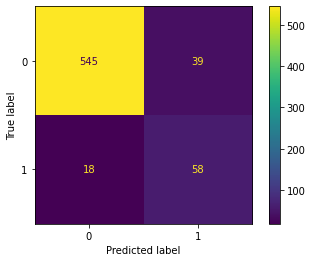

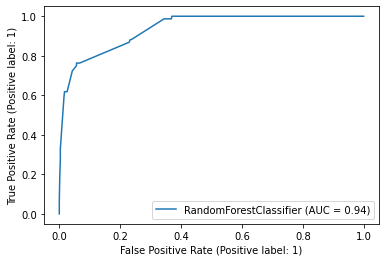

Number of test episodes: 1000


Plotting: 100%|██████████| 20/20 [24:46<00:00, 74.31s/it]





#########################################
Abstraction level: 4
abstract states: 34
Concrete states 424962
ratio 8.000715358079075e-05
********************** reporting the result of the model **************************
The score for train data is 0.8779220779220779
The score for test data is 0.8848484848484849


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9342105263157895
the test recall for the class no is 0.8784246575342466
the training recall for the class yes is 0.920863309352518
the training recall for the class no is 0.8736616702355461


--------------------------------------precision------------------------------
the test precision for the class yes is 0.5
the test precision for the class no is 0.9903474903474904
the training precision for the class yes is 0.419672131147541
the training precision for the class no is 0.9910931174089069



              precision    recall  f1-score   support

         NO  

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


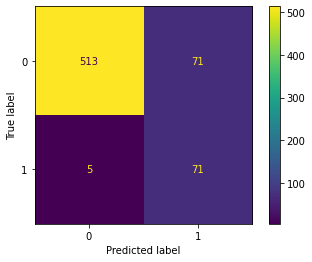

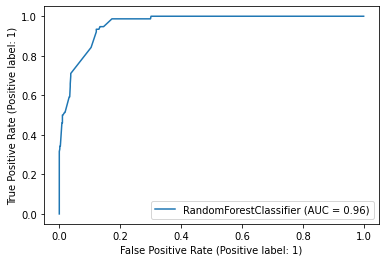

Number of test episodes: 1000


Plotting: 100%|██████████| 20/20 [25:27<00:00, 76.36s/it]





#########################################
Abstraction level: 3
abstract states: 43
Concrete states 424962
ratio 0.00010118551776394125
********************** reporting the result of the model **************************
The score for train data is 0.8064935064935065
The score for test data is 0.7575757575757576


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.8289473684210527
the test recall for the class no is 0.7482876712328768
the training recall for the class yes is 0.9280575539568345
the training recall for the class no is 0.7944325481798715


--------------------------------------precision------------------------------
the test precision for the class yes is 0.3
the test precision for the class no is 0.9711111111111111
the training precision for the class yes is 0.30935251798561153
the training precision for the class no is 0.9910952804986642



              precision    recall  f1-score   support

         

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


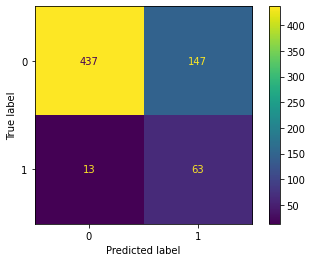

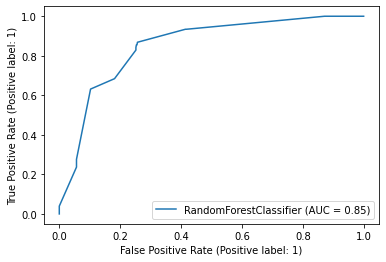

Number of test episodes: 1000


Plotting: 100%|██████████| 20/20 [26:05<00:00, 78.26s/it]





#########################################
Abstraction level: 2
abstract states: 67
Concrete states 424962
ratio 0.0001576611555856759
********************** reporting the result of the model **************************
The score for train data is 0.9701298701298702
The score for test data is 0.9318181818181818


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.7105263157894737
the test recall for the class no is 0.9606164383561644
the training recall for the class yes is 0.9424460431654677
the training recall for the class no is 0.9728765167737331


--------------------------------------precision------------------------------
the test precision for the class yes is 0.7012987012987013
the test precision for the class no is 0.9622641509433962
the training precision for the class yes is 0.7751479289940828
the training precision for the class no is 0.9941648431801605



              precision    recall  f1-score   suppo

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


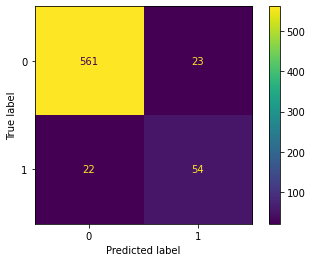

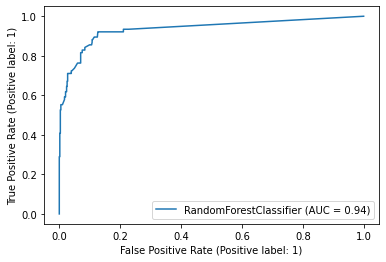

Number of test episodes: 1000


Plotting: 100%|██████████| 20/20 [24:23<00:00, 73.15s/it]





#########################################
Abstraction level: 1.5
abstract states: 82
Concrete states 424962
ratio 0.00019295842922426005
********************** reporting the result of the model **************************
The score for train data is 0.9844155844155844
The score for test data is 0.9333333333333333


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.7368421052631579
the test recall for the class no is 0.958904109589041
the training recall for the class yes is 0.9856115107913669
the training recall for the class no is 0.9842969307637401


--------------------------------------precision------------------------------
the test precision for the class yes is 0.7
the test precision for the class no is 0.9655172413793104
the training precision for the class yes is 0.8616352201257862
the training precision for the class no is 0.998551774076756



              precision    recall  f1-score   support

         N

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


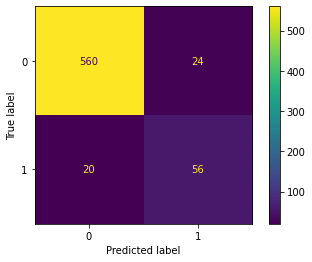

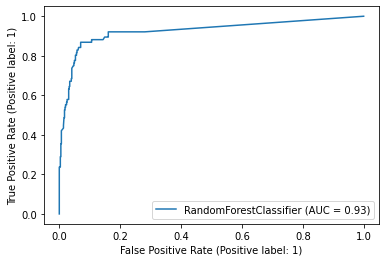

Number of test episodes: 1000


Plotting: 100%|██████████| 20/20 [24:15<00:00, 72.79s/it]





#########################################
Abstraction level: 1
abstract states: 115
Concrete states 424962
ratio 0.0002706124312291452
********************** reporting the result of the model **************************
The score for train data is 0.9948051948051948
The score for test data is 0.9484848484848485


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.6447368421052632
the test recall for the class no is 0.988013698630137
the training recall for the class yes is 0.9928057553956835
the training recall for the class no is 0.9950035688793719


--------------------------------------precision------------------------------
the test precision for the class yes is 0.875
the test precision for the class no is 0.9552980132450332
the training precision for the class yes is 0.9517241379310345
the training precision for the class no is 0.9992831541218637



              precision    recall  f1-score   support

         

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


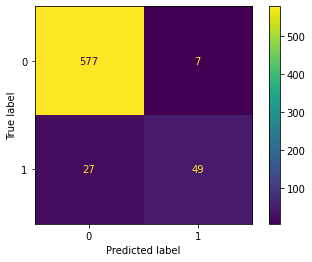

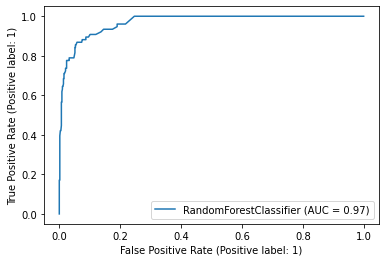

Number of test episodes: 1000


Plotting: 100%|██████████| 20/20 [25:10<00:00, 75.53s/it]





#########################################
Abstraction level: 0.8
abstract states: 140
Concrete states 424962
ratio 0.00032944122062678543
********************** reporting the result of the model **************************
The score for train data is 0.9961038961038962
The score for test data is 0.943939393939394


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.6447368421052632
the test recall for the class no is 0.9828767123287672
the training recall for the class yes is 1.0
the training recall for the class no is 0.9957173447537473


--------------------------------------precision------------------------------
the test precision for the class yes is 0.8305084745762712
the test precision for the class no is 0.9550748752079867
the training precision for the class yes is 0.9586206896551724
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.96

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


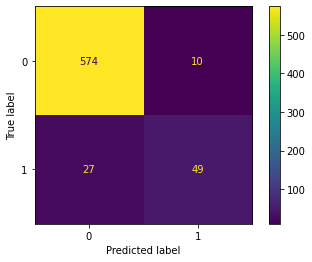

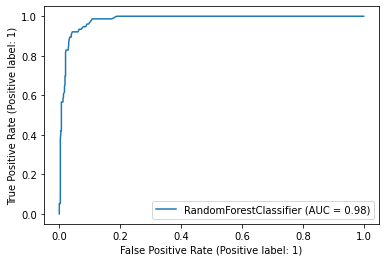

Number of test episodes: 1000


Plotting: 100%|██████████| 20/20 [27:40<00:00, 83.01s/it]





#########################################
Abstraction level: 0.5
abstract states: 226
Concrete states 424962
ratio 0.0005318122561546679
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9590909090909091


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.6578947368421053
the test recall for the class no is 0.9982876712328768
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9803921568627451
the test precision for the class no is 0.9573070607553367
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.96      1.00      0.98       584
         yes  

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


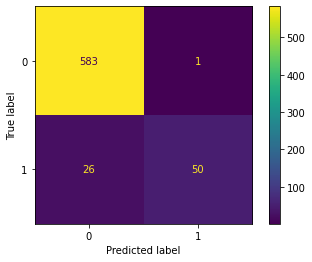

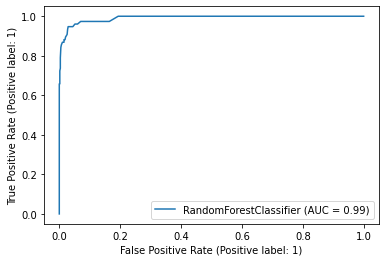

Number of test episodes: 1000


Plotting: 100%|██████████| 20/20 [30:02<00:00, 90.13s/it]





#########################################
Abstraction level: 0.1
abstract states: 1913
Concrete states 424962
ratio 0.004501578964707433
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9878787878787879


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.8947368421052632
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9864864864864865
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.99      1.00      0.99       584
         yes       1.00      0.89      0.94 

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


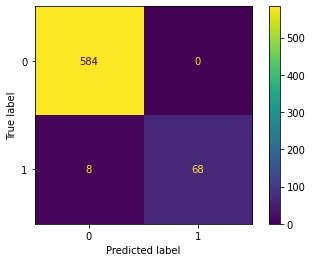

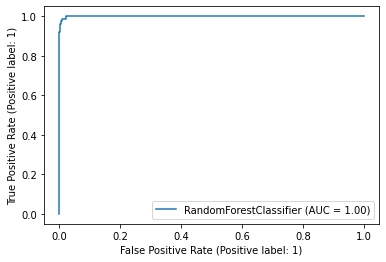

Number of test episodes: 1000


Plotting: 100%|██████████| 20/20 [1:04:41<00:00, 194.08s/it]





#########################################
Abstraction level: 0.05
abstract states: 4655
Concrete states 424962
ratio 0.010953920585840616
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9666666666666667


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.7105263157894737
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9636963696369637
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.96      1.00      0.98       584
         yes       1.00      0.71      0.83

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


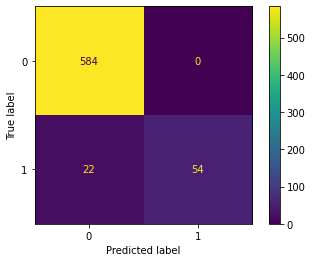

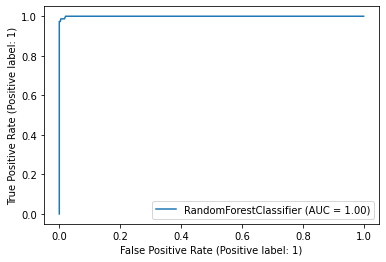

Number of test episodes: 1000


Plotting: 100%|██████████| 20/20 [47:43<00:00, 143.16s/it]





#########################################
Abstraction level: 0.01
abstract states: 34003
Concrete states 424962
ratio 0.08001421303551846
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9727272727272728


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.7763157894736842
the test recall for the class no is 0.9982876712328768
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9833333333333333
the test precision for the class no is 0.9716666666666667
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.97      1.00      0.98       584
         yes 

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


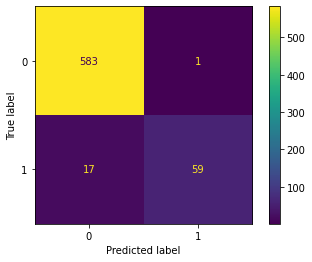

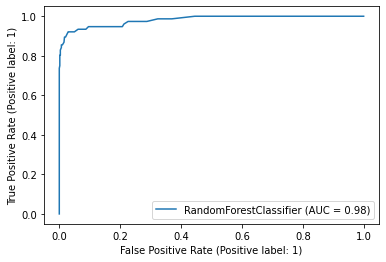

Number of test episodes: 1000


Plotting: 100%|██████████| 20/20 [6:16:11<00:00, 1128.60s/it]  





#########################################
Abstraction level: 0.005
abstract states: 82214
Concrete states 424962
ratio 0.19346200366150385
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9515151515151515


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.5921052631578947
the test recall for the class no is 0.9982876712328768
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9782608695652174
the test precision for the class no is 0.9495114006514658
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.95      1.00      0.97       584
         yes

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


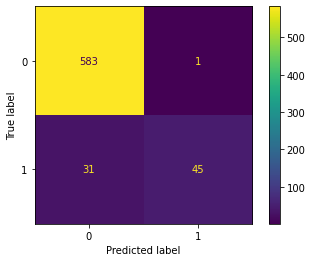

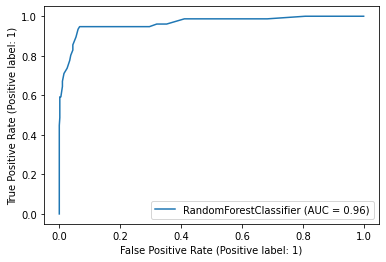

Number of test episodes: 1000


Plotting: 100%|██████████| 20/20 [14:51:53<00:00, 2675.68s/it]  


In [22]:
# path = '/src/Config_CartPole.ini'
    # CartPole_config = Config(abstraction_level=d, Read_abstraction_from_file=True, config_file=path)

d_set=[5,4,3,2,1.5,1,0.8,0.5,0.1,0.05,0.01,0.005] #abstraction levels you want to explore



Drive_model  =f"{Dataset_path}Trained_agent/dqn-168.pkl"


env2 = gym.make('CartPole-v1')
env2 = StoreWrapper(env2)
model = DQN('MlpPolicy',env=env2, verbose=1)
model = model.load(Drive_model)

with open(f"{Dataset_path}Random_episodes/FRT_68_training.pkl", 'rb') as file2:
    Training_episodes = pickle.load(file2)
print('Number of episodes:',len(Training_episodes))
for d in d_set:
    print(f'\n\n\n#########################################\nAbstraction level: {d}')
    # unique1 = CartPole_config.unique1
    #read unique1 from pickle
    Read_from_data = False # set to True if you want to read abstract classes from pickle file for the first time set to False to generate the pickle file
    if Read_from_data:
        with open(f'{Dataset_path}/ABS/Abstraction_data_final_{d}.pickle', 'rb') as file2:
            unique1 = pickle.load(file2)
        uni1=np.array(unique1)
    if not Read_from_data:
        # print('Reading unique1 from file')
        # assert False
        unique1,uni1 = Abstract_classes(Training_episodes,d,model)
        with open(f'{Dataset_path}/ABS/Abstraction_data_final_{d}.pickle', 'wb') as f:
            pickle.dump(unique1, f)


    data1_x_b, data1_y_b, data1_y_f_b = ML_first_representation_func_based(d,is_functional_fault,is_reward_fault,model,Training_episodes,unique1,EPSILON,THRESHOLD)


    #########################################################  Train ML - Functional fault predictor #############


    X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(data1_x_b, data1_y_f_b, test_size=0.30, random_state=42)
    RF_FF_1rep = RandomForestClassifier(random_state=0, class_weight='balanced')
    RF_FF_1rep.fit(X_train_f,y_train_f)
    report(RF_FF_1rep,X_train_f,y_train_f,X_test_f,y_test_f)
    #save RF_FF_1rep
    with open(f'{Dataset_path}/ML_models/RF_FF_1rep_{d}.pickle', 'wb') as file2:
        pickle.dump(RF_FF_1rep, file2)

    ######################################################### Read FRT and FRTS from pickle #############
    with open(f'{Dataset_path}/Random_episodes/FRT_test_68.pkl', 'rb') as file2:
        FRT = pickle.load(file2)
    print("Number of test episodes:",len(FRT))
    #########################################################  Plot Risk and Position #############
    newpath = f'Abs_{d}'
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    #plot risk and position for 200 episodes
    Num_plot = 200
    if len(FRT)<Num_plot:
        print("number of available episodes is less than {Num_plot}}")
        Num_plot = len(FRT)
    print("Number of episodes to plot:",Num_plot)
    for i in tqdm(range(0,Num_plot,10), desc="Plotting", total=Num_plot//10):
        Plot_all(FRT[i:i+10],d,unique1,model,RF_FF_1rep,save=True,show=False,data_chunk=i,path=newpath)

# Run

Loading a model without an environment, this model cannot be trained until it has a valid environment.
Number of episodes: 2200



#########################################
Abstraction level: 0.4
abstract states: 294
Concrete states 424962
ratio 0.0006918265633162494
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9651515151515152


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.6973684210526315
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9621087314662273
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision  

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


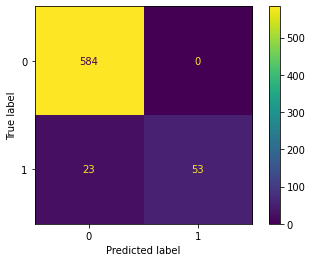

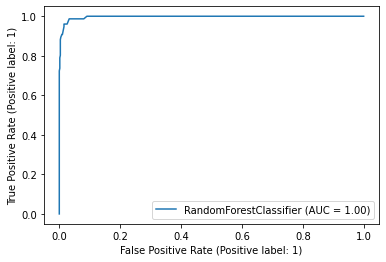

Number of test episodes: 1000
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [27:02<00:00, 81.13s/it]





#########################################
Abstraction level: 0.3
abstract states: 414
Concrete states 424962
ratio 0.0009742047524249227
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9878787878787879


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.8947368421052632
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9864864864864865
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.99      1.00      0.99       584
         yes       1.00      0.89      0.94 

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


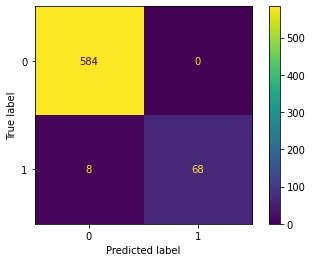

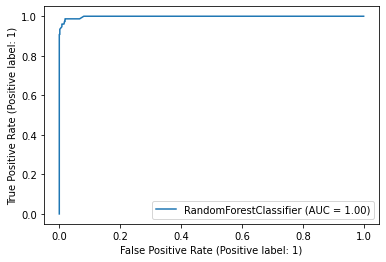

Number of test episodes: 1000
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [26:14<00:00, 78.74s/it]





#########################################
Abstraction level: 0.2
abstract states: 709
Concrete states 424962
ratio 0.0016683844673170778
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9893939393939394


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9078947368421053
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.988155668358714
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.99      1.00      0.99       584
         yes       1.00      0.91      0.95  

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


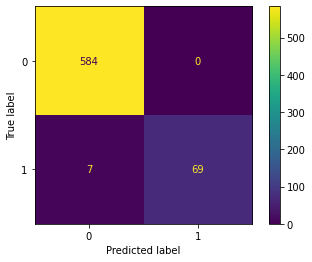

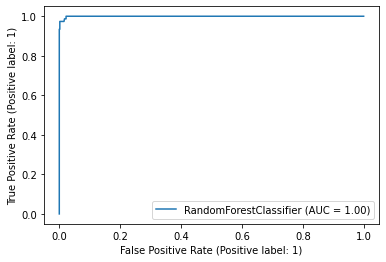

Number of test episodes: 1000
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [27:25<00:00, 82.26s/it]


In [6]:
# path = 'C:/Users/Student/Desktop/vs_git/HazardDetection/CartPole/src/Config_CartPole.ini'
    # CartPole_config = Config(abstraction_level=d, Read_abstraction_from_file=True, config_file=path)
EPSILON = 0.05
THRESHOLD = 70
d_set=[0.4,0.3,0.2]


Drive_model  ="c:/Users/Student/Desktop/vs_git/HazardDetection/Final/Trained_agent/dqn-168.pkl"


env2 = gym.make('CartPole-v1')
env2 = StoreWrapper(env2)
model = DQN('MlpPolicy',env=env2, verbose=1)
model = model.load(Drive_model)

with open(f'C:/Users/Student/Desktop/vs_git/HazardDetection/Final/Data_final/Random_episodes/FRT_68_training.pkl', 'rb') as file2:
    Training_episodes = pickle.load(file2)
print('Number of episodes:',len(Training_episodes))
for d in d_set:
    print(f'\n\n\n#########################################\nAbstraction level: {d}')
    # unique1 = CartPole_config.unique1
    #read unique1 from pickle
    Read_from_data = False
    if Read_from_data:
        assert False
        with open(f'updated ....  Data_final/ABS/Abstraction_data_final_{d}.pickle', 'rb') as file2:
            unique1 = pickle.load(file2)
        uni1=np.array(unique1)
    if not Read_from_data:
        # print('Reading unique1 from file')
        # assert False
        unique1,uni1 = Abstract_classes(Training_episodes,d,model)
        with open(f'Data_final/ABS/Abstraction_data_final_{d}.pickle', 'wb') as f:
            pickle.dump(unique1, f)


    data1_x_b, data1_y_b, data1_y_f_b = ML_first_representation_func_based(d,is_functional_fault,is_reward_fault,model,Training_episodes,unique1,EPSILON,THRESHOLD)


    #########################################################  Train ML - Functional fault predictor #############


    X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(data1_x_b, data1_y_f_b, test_size=0.30, random_state=42)
    RF_FF_1rep = RandomForestClassifier(random_state=0, class_weight='balanced')
    RF_FF_1rep.fit(X_train_f,y_train_f)
    report(RF_FF_1rep,X_train_f,y_train_f,X_test_f,y_test_f)
    #save RF_FF_1rep
    with open(f'Data_final/ML_models/RF_FF_1rep_{d}.pickle', 'wb') as file2:
        pickle.dump(RF_FF_1rep, file2)

    ######################################################### Read FRT and FRTS from pickle #############
    with open(f'C:/Users/Student/Desktop/vs_git/HazardDetection/Final/Data_final/Random_episodes/FRT_test_68.pkl', 'rb') as file2:
        FRT = pickle.load(file2)
    print("Number of test episodes:",len(FRT))
    # with open(f'C:/Users/Student/Desktop/vs_git/HazardDetection/Data_Cartpole/Random_episodes/FRT.pkl', 'rb') as file2:
    #     FRTS = pickle.load(file2)
    # print(len(FRT))
    # assert len(FRT)<100
    #load hd model from pickle
    # with open(f'c:/Users/Student/Desktop/vs_git/HazardDetection/Data_Cartpole/ML_models/RF_FF_1rep_{d}.pickle', 'wb') as file2:
    #     pickle.dump(RF_FF_1rep, file2)
    # HD_model_path1 = f'C:/Users/Student/Desktop/vs_git/HazardDetection/Data_Cartpole/ML_models'
    # HD_model_path = f'{HD_model_path1}/RF_FF_1rep_{d}.pickle'
    # with open(HD_model_path, 'rb') as file2:
    #     HD_model = pickle.load(file2)
    #########################################################  Plot Risk and Position #############
    newpath = f'C:/Users/Student/Desktop/vs_git/HazardDetection/Final/Plots_CartPole/v1/Abs_{d}'
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    #plot risk and position for 200 episodes
    Num_plot = 200
    if len(FRT)<Num_plot:
        print("number of available episodes is less than {Num_plot}}")
        Num_plot = len(FRT)
    print("Number of episodes to plot:",Num_plot)
    for i in tqdm(range(0,Num_plot,10), desc="Plotting", total=Num_plot//10):
        Plot_all(FRT[i:i+10],d,unique1,model,RF_FF_1rep,save=True,show=False,data_chunk=i,path=newpath)

# Running for values between 0.1 and 0.2 (inside the optimal range)

Loading a model without an environment, this model cannot be trained until it has a valid environment.
Number of episodes: 2200



#########################################
Abstraction level: 0.11
abstract states: 1659
Concrete states 424962
ratio 0.0039038784644274075
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9939393939393939


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9473684210526315
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9931972789115646
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


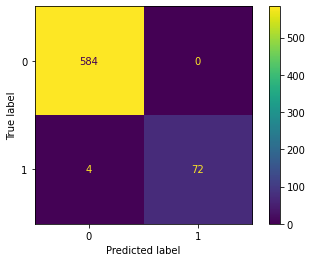

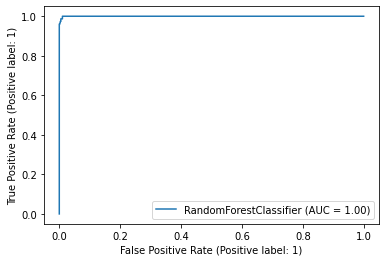

Number of test episodes: 1000
Number of episodes to plot: 50


Plotting: 100%|██████████| 5/5 [13:12<00:00, 158.54s/it]





#########################################
Abstraction level: 0.12
abstract states: 1481
Concrete states 424962
ratio 0.003485017483916209
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9878787878787879


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9078947368421053
the test recall for the class no is 0.9982876712328768
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9857142857142858
the test precision for the class no is 0.988135593220339
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.99      1.00      0.99       584
         yes  

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


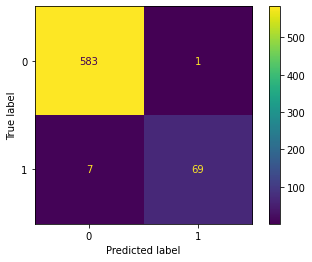

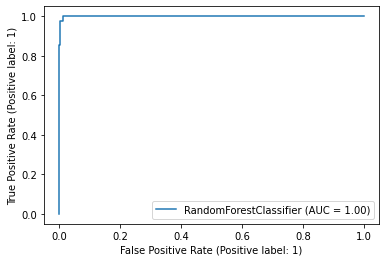

Number of test episodes: 1000
Number of episodes to plot: 50


Plotting: 100%|██████████| 5/5 [12:02<00:00, 144.60s/it]





#########################################
Abstraction level: 0.14
abstract states: 1172
Concrete states 424962
ratio 0.0027578936469613755
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.990909090909091


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9210526315789473
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9898305084745763
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.99      1.00      0.99       584
         yes       1.00      0.92      0.96

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


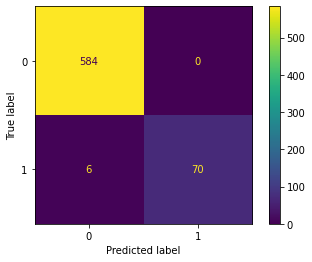

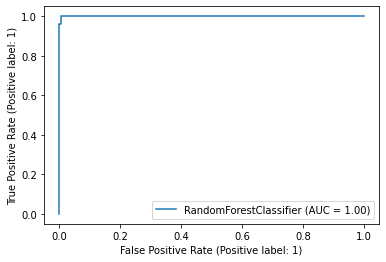

Number of test episodes: 1000
Number of episodes to plot: 50


Plotting: 100%|██████████| 5/5 [10:16<00:00, 123.24s/it]





#########################################
Abstraction level: 0.15
abstract states: 1081
Concrete states 424962
ratio 0.002543756853553965
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9924242424242424


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9342105263157895
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9915110356536503
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.99      1.00      1.00       584
         yes       1.00      0.93      0.97

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


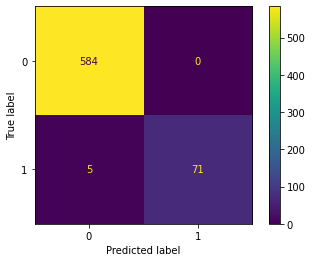

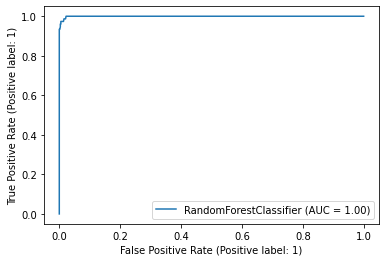

Number of test episodes: 1000
Number of episodes to plot: 50


Plotting: 100%|██████████| 5/5 [09:29<00:00, 113.97s/it]





#########################################
Abstraction level: 0.17
abstract states: 908
Concrete states 424962
ratio 0.002136661630922294
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9924242424242424


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9342105263157895
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9915110356536503
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.99      1.00      1.00       584
         yes       1.00      0.93      0.97 

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


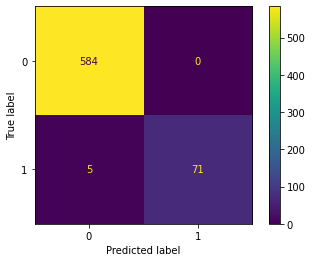

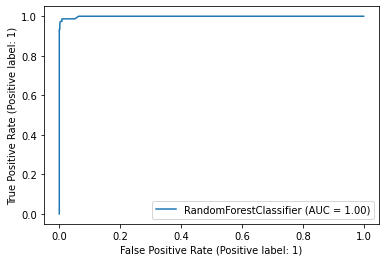

Number of test episodes: 1000
Number of episodes to plot: 50


Plotting: 100%|██████████| 5/5 [09:45<00:00, 117.02s/it]


In [7]:
#this part could be easily automated we did it manually to analize the results

EPSILON = 0.05
THRESHOLD = 70
d_set=[0.11, 0.12,0.14,0.15,0.17]


Drive_model  ="c:/Users/Student/Desktop/vs_git/HazardDetection/Final/Trained_agent/dqn-168.pkl"


env2 = gym.make('CartPole-v1')
env2 = StoreWrapper(env2)
model = DQN('MlpPolicy',env=env2, verbose=1)
model = model.load(Drive_model)

with open(f'{Dataset_path}/Random_episodes/FRT_68_training.pkl', 'rb') as file2:
    Training_episodes = pickle.load(file2)
print('Number of episodes:',len(Training_episodes))
for d in d_set:
    print(f'\n\n\n#########################################\nAbstraction level: {d}')
    # unique1 = CartPole_config.unique1
    #read unique1 from pickle
    Read_from_data = False
    if Read_from_data:
        assert False
        with open(f'{Dataset_path}/ABS/Abstraction_data_final_{d}.pickle', 'rb') as file2:
            unique1 = pickle.load(file2)
        uni1=np.array(unique1)
    if not Read_from_data:
        # print('Reading unique1 from file')
        # assert False
        unique1,uni1 = Abstract_classes(Training_episodes,d,model)
        with open(f'{Dataset_path}ABS/Abstraction_data_final_{d}.pickle', 'wb') as f:
            pickle.dump(unique1, f)


    data1_x_b, data1_y_b, data1_y_f_b = ML_first_representation_func_based(d,is_functional_fault,is_reward_fault,model,Training_episodes,unique1,EPSILON,THRESHOLD)


    #########################################################  Train ML - Functional fault predictor #############


    X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(data1_x_b, data1_y_f_b, test_size=0.30, random_state=42)
    RF_FF_1rep = RandomForestClassifier(random_state=0, class_weight='balanced')
    RF_FF_1rep.fit(X_train_f,y_train_f)
    report(RF_FF_1rep,X_train_f,y_train_f,X_test_f,y_test_f)
    #save RF_FF_1rep
    with open(f'{Dataset_path}/ML_models/RF_FF_1rep_{d}.pickle', 'wb') as file2:
        pickle.dump(RF_FF_1rep, file2)

    ######################################################### Read FRT and FRTS from pickle #############
    with open(f'{Dataset_path}/Random_episodes/FRT_test_68.pkl', 'rb') as file2:
        FRT = pickle.load(file2)
    print("Number of test episodes:",len(FRT))
    # with open(f'C:/Users/Student/Desktop/vs_git/HazardDetection/Data_Cartpole/Random_episodes/FRT.pkl', 'rb') as file2:
    #     FRTS = pickle.load(file2)
    # print(len(FRT))
    # assert len(FRT)<100
    #load hd model from pickle
    # with open(f'c:/Users/Student/Desktop/vs_git/HazardDetection/Data_Cartpole/ML_models/RF_FF_1rep_{d}.pickle', 'wb') as file2:
    #     pickle.dump(RF_FF_1rep, file2)
    # HD_model_path1 = f'C:/Users/Student/Desktop/vs_git/HazardDetection/Data_Cartpole/ML_models'
    # HD_model_path = f'{HD_model_path1}/RF_FF_1rep_{d}.pickle'
    # with open(HD_model_path, 'rb') as file2:
    #     HD_model = pickle.load(file2)
    #########################################################  Plot Risk and Position #############
    newpath = f'/Abs_{d}'
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    #plot risk and position for 200 episodes
    Num_plot = 50
    if len(FRT)<Num_plot:
        print("number of available episodes is less than {Num_plot}}")
        Num_plot = len(FRT)
    print("Number of episodes to plot:",Num_plot)
    for i in tqdm(range(0,Num_plot,10), desc="Plotting", total=Num_plot//10):
        Plot_all(FRT[i:i+10],d,unique1,model,RF_FF_1rep,save=True,show=False,data_chunk=i,path=newpath)